# examples

## Example of VAE on MNIST dataset using MLP from keras官方

https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

The VAE has a modular design（采用模块化设计）.   
The encoder, decoder and VAE are 3 models that share weights. 

After training the VAE model, 
* the encoder can be used to generate latent vectors.
* The decoder can be used to generate MNIST digits by sampling the latent vector from a Gaussian distribution with mean = 0 and std = 1.
### Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-Encoding Variational Bayes."
https://arxiv.org/abs/1312.6114

In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


In [26]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape

(60000, 28, 28)

In [27]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [28]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2  # 隐变量取2维只是为了方便后面画图
epochs = 50

### VAE model = encoder + decoder

#### build encoder model


In [29]:
input_shape

(784,)

In [30]:
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
# 算p(Z|X)的均值和方差
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

#### reparameterization trick 重参数技巧
instead of sampling from Q(z|X), sample epsilon = N(0,I)

`z = z_mean + sqrt(var) * epsilon`

In [46]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
#     batch = K.shape(z_mean)[0]
#     dim = K.int_shape(z_mean)[1]
#     # by default, random_normal has mean = 0 and std = 1.0
#     epsilon = K.random_normal(shape=(batch, dim))
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

#### 重参数层，相当于给输入加入噪声

In [31]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

#### instantiate encoder model

In [32]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [33]:
# plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

#### build decoder model 解码层，也就是生成器部分

In [47]:
latent_dim

2

In [34]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

#### instantiate decoder model

In [35]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


### instantiate VAE model

In [36]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


### main

In [37]:
parser = argparse.ArgumentParser()
help_ = "Load h5 model trained weights"
parser.add_argument("-w", "--weights", help=help_)
help_ = "Use mse loss instead of binary cross entropy (default)"
parser.add_argument("-m",
                    "--mse",
                    help=help_, action='store_true')
args = parser.parse_args(args=[])
args

Namespace(mse=False, weights=None)

In [38]:
models = (encoder, decoder)
data = (x_test, y_test)

In [39]:
# VAE loss = mse_loss or xent_loss + kl_loss
if args.mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

In [40]:
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.summary()
# plot_model(vae,
#            to_file='vae_mlp.png',
#            show_shapes=True)

In [41]:
if args.weights:
    vae.load_weights(args.weights)
else:
    # train the autoencoder
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    vae.save_weights('vae_mlp_mnist.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 143us/step - loss: 197.3879 - val_loss: 172.1175
Epoch 2/50
60000/60000 [==============================] - 9s 153us/step - loss: 168.8271 - val_loss: 166.2865
Epoch 3/50
60000/60000 [==============================] - 8s 141us/step - loss: 164.8168 - val_loss: 163.6841
Epoch 4/50
60000/60000 [==============================] - 8s 128us/step - loss: 162.6589 - val_loss: 161.9655
Epoch 5/50
60000/60000 [==============================] - 8s 129us/step - loss: 160.9381 - val_loss: 160.4063
Epoch 6/50
60000/60000 [==============================] - 8s 136us/step - loss: 159.4759 - val_loss: 159.2472
Epoch 7/50
60000/60000 [==============================] - 9s 147us/step - loss: 158.2067 - val_loss: 158.1077
Epoch 8/50
60000/60000 [==============================] - 9s 148us/step - loss: 157.1061 - val_loss: 157.0940
Epoch 9/50
60000/60000 [==============================] - 9s 149us/ste

In [3]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

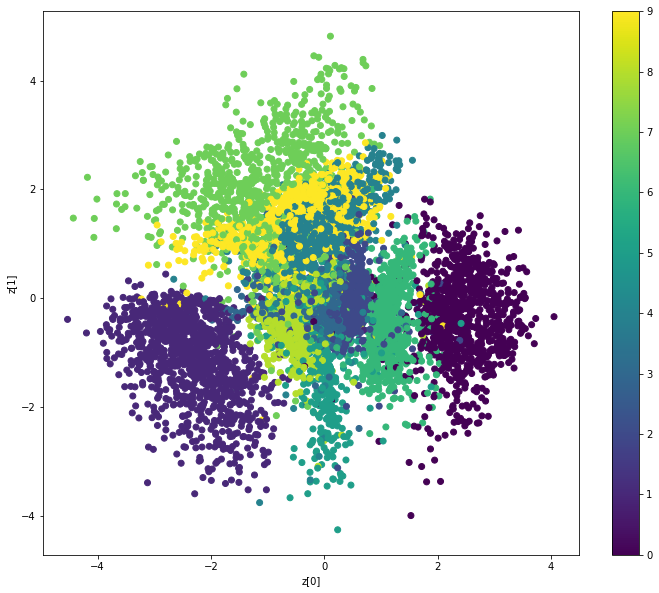

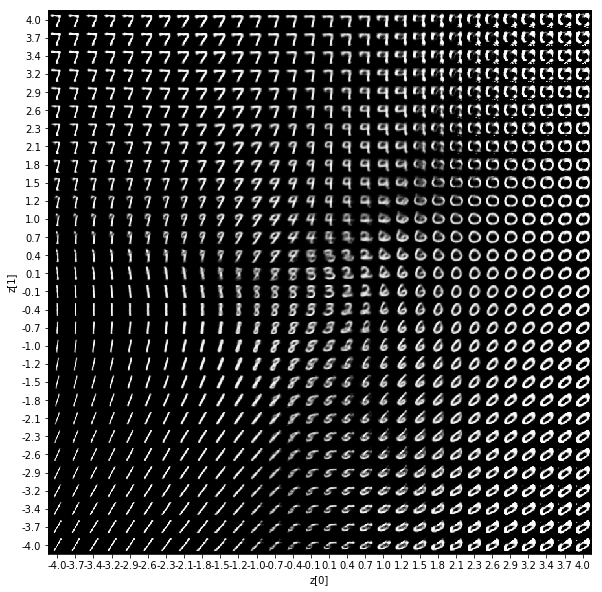

In [42]:
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")

In [49]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

In [55]:
len(x_test_encoded)

3

In [54]:
batch_size

128

In [56]:
x_test_encoded[0].shape

(10000, 2)

In [57]:
x_test_encoded[1].shape

(10000, 2)

In [58]:
x_test_encoded[2].shape

(10000, 2)

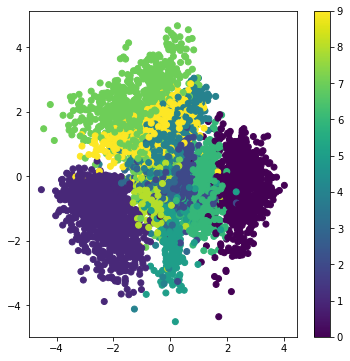

In [60]:

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2][:, 0], x_test_encoded[2][:, 1], c=y_test)
plt.colorbar()
plt.show()